In [1]:
import re
import numpy as np
import math
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline
import sklearn.datasets
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import OneHotEncoder


# Data loading

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='data/mnist')

In [3]:
n = 60000

randidx = np.random.choice(mnist.target.shape[0], n, replace=False)

# This cell includes the splittign of training and test set.
X = mnist['data'][randidx]

shapeX = [70000, 28, 28]
X = 2*(X / 255) - 1 #Normalize to -1,1

y = mnist['target'][randidx]
enc = preprocessing.OneHotEncoder()
y = enc.fit_transform(y.reshape(-1, 1)).toarray()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
def imshow(x, ax=None):
    rescaled = (255*(x + 1)//2).astype('uint8')
    if ax is None:
        plt.imshow(rescaled.reshape(shapeX[1],shapeX[2]), plt.cm.gray)
    else:
        ax.imshow(rescaled.reshape(shapeX[1],shapeX[2]), plt.cm.gray)

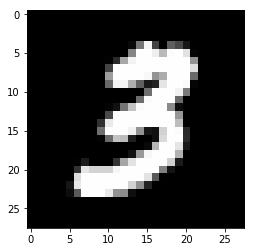

In [5]:
plt.imshow(X[0].reshape(shapeX[1],shapeX[2]), plt.cm.gray)

# Optimal Encoding

In [6]:
from networks import MLP
from OptimalEncoding import OptimalEncoding

Instructions for updating:
Use the retry module or similar alternatives.


## Autoencoding

In [7]:
n_in = X.shape[-1]
n_cts = 2
n_categorical = 1

depth = 1
widths_in = [500]
widths_out = widths_in[::-1]

In [8]:
widths_in[::-1]

[500]

In [9]:
encoder = MLP(n_in, 2*n_cts + n_categorical, depth, widths_in)
decoder = MLP(n_cts + n_categorical, n_in, depth, widths_out)

In [10]:
oe = OptimalEncoding(encoder, decoder, n_cts, n_categorical)

100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s]


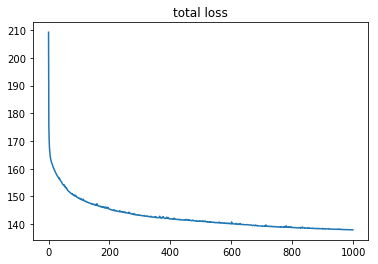

In [11]:
oe.train(X_train, epochs=1000, batch_size=100, lr=1e-2, tau_rate = 1e-4)

In [12]:
zhat = oe.encode(X_train)

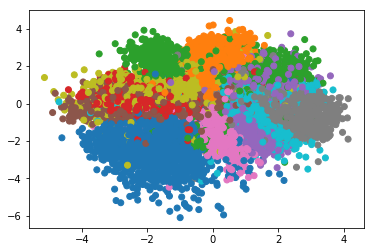

In [13]:
plt.scatter(zhat[:,0], zhat[:,1], c=np.argmax(y_train, 1), cmap=plt.get_cmap('tab10'))

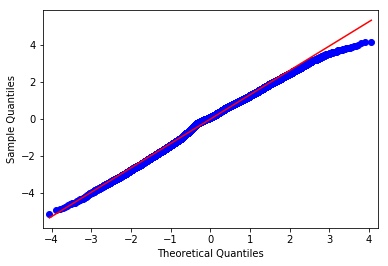

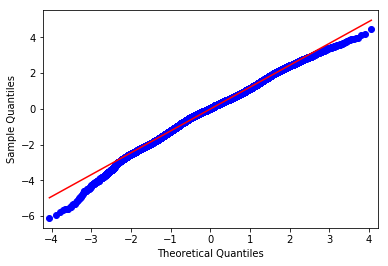

In [14]:
from statsmodels.graphics.gofplots import qqplot
qq1 = qqplot(zhat[:,0], line='s')
qq2 = qqplot(zhat[:,1], line='s')

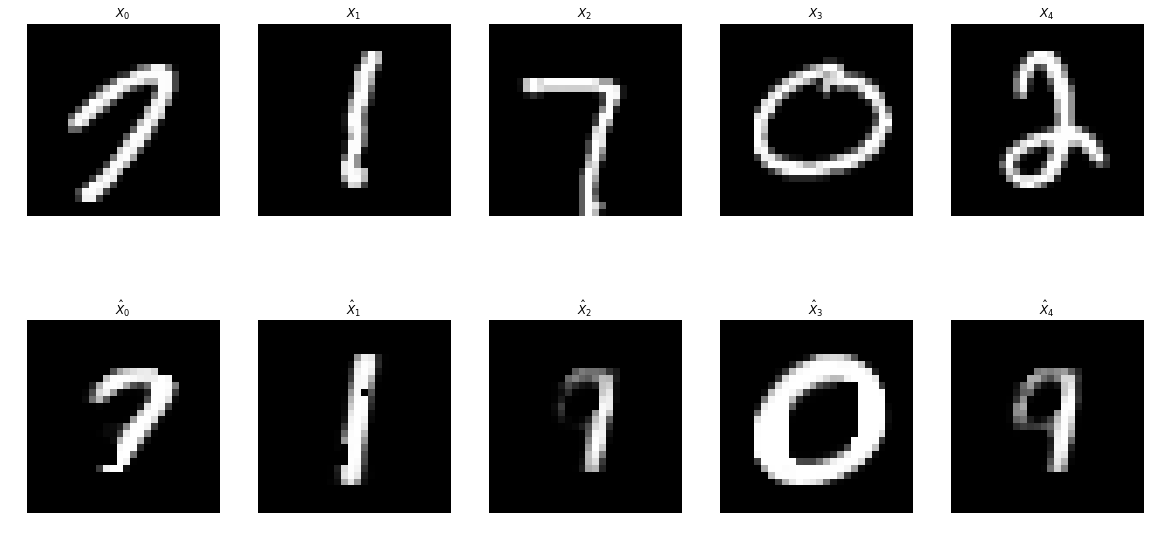

In [15]:
xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_train[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$" %(j))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

In [16]:
np.mean(zhat[:,-n_categorical:], 0)

array([ 1.], dtype=float32)

In [17]:
zhat = oe.encode(X_test)

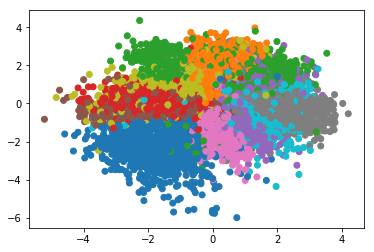

In [18]:
plt.scatter(zhat[:,0], zhat[:,1], c=np.argmax(y_test, 1), cmap=plt.get_cmap('tab10'))

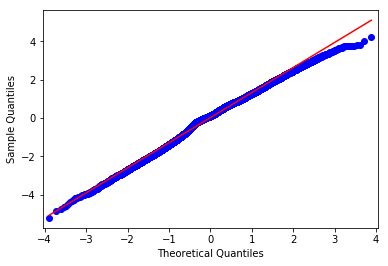

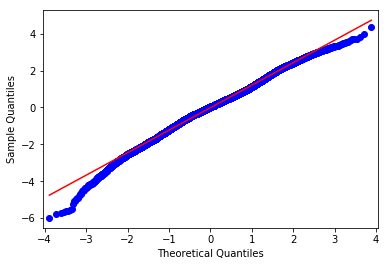

In [19]:
from statsmodels.graphics.gofplots import qqplot
qq1 = qqplot(zhat[:,0], line='s')
qq2 = qqplot(zhat[:,1], line='s')

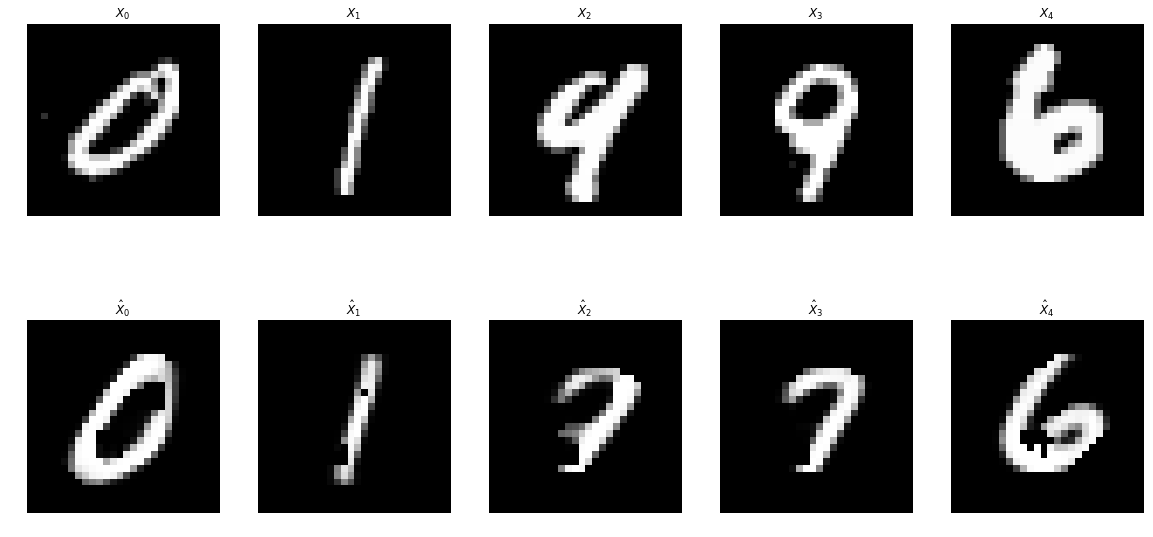

In [20]:
xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_test[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$" %(j))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

In [21]:
print(np.mean(zhat, 0))

[ 0.015318   -0.01501953  1.        ]


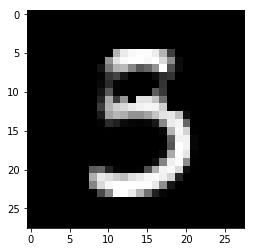

In [22]:
z_cts = np.random.normal(size=(1, n_cts))
if n_categorical > 0:
    onehot = OneHotEncoder(n_values=n_categorical, sparse=False)
    z_categorical = onehot.fit_transform(np.random.randint(n_categorical, size=(1,1)))
    z = np.hstack((z_cts, z_categorical))
else: z = z_cts
Xgen = oe.decode(z)
plt.imshow(Xgen[0].reshape(shapeX[1],shapeX[2]), plt.cm.gray)

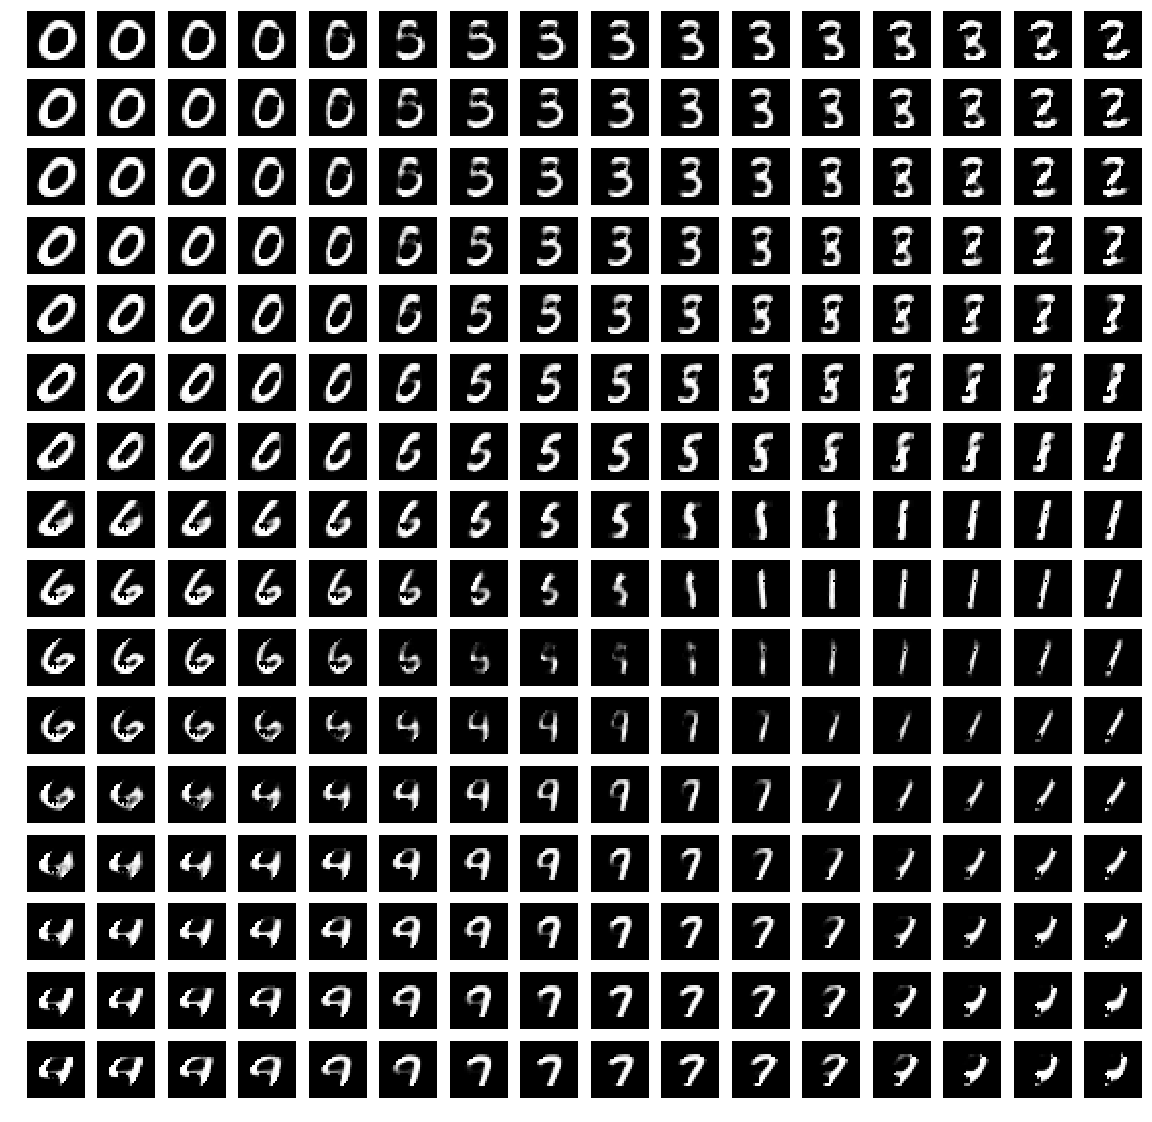

In [23]:
vals = np.arange(-2,2,.25)
n = len(vals)

fig, ax = plt.subplots(figsize = (20,20), nrows=n, ncols=n)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        z_aug = np.copy(z)
        z_aug[:,0] = vals[i]
        z_aug[:,1] = vals[j]
        Xgen = oe.decode(z_aug)
        subplt.imshow(Xgen[0].reshape(shapeX[1],shapeX[2]), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

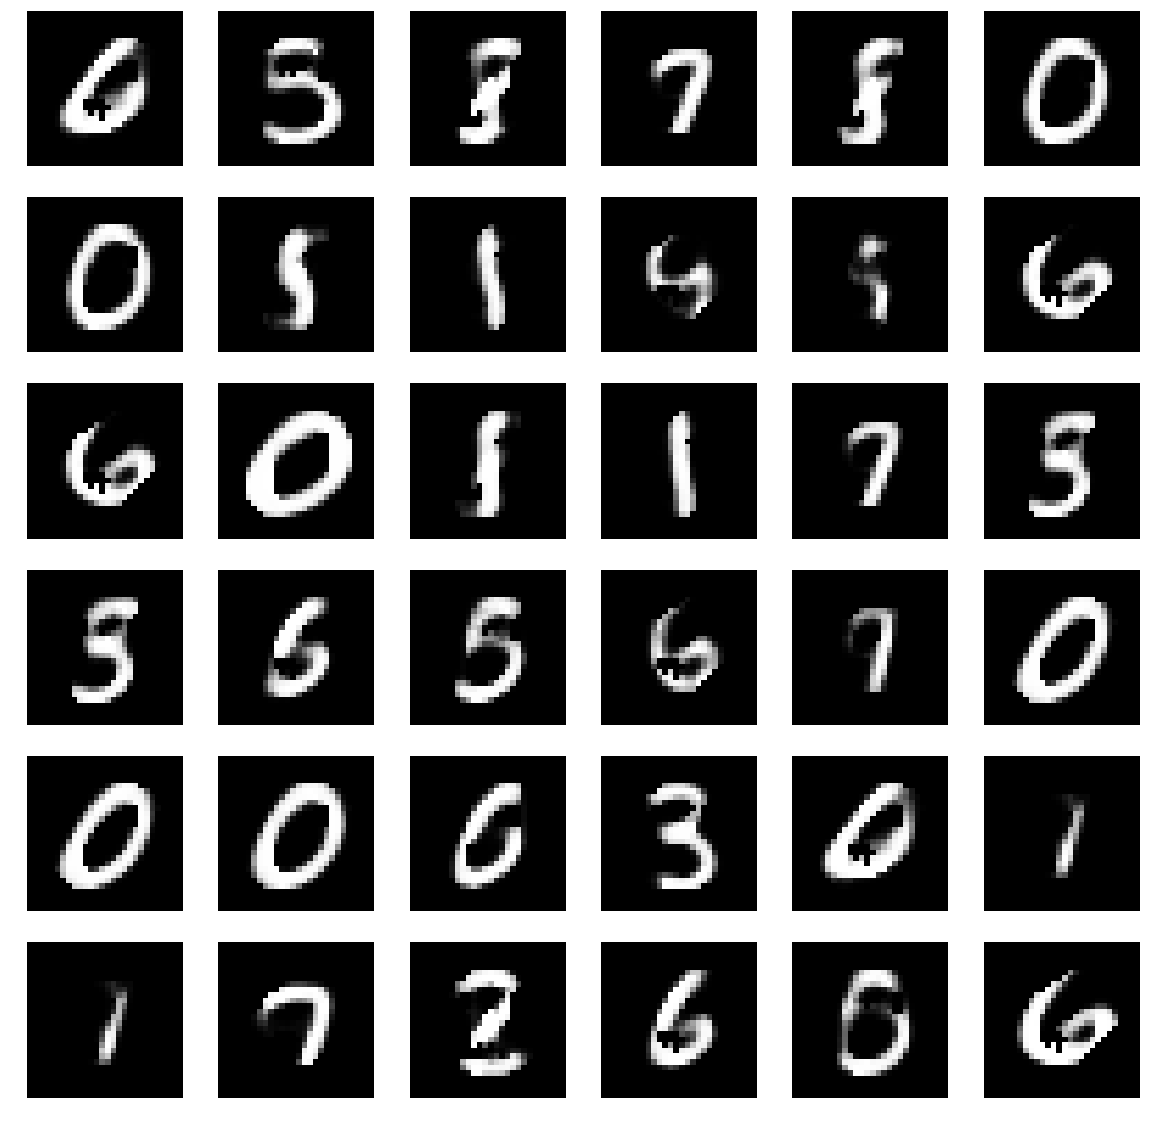

In [24]:
Xgen = oe.sample(36)

xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (20,20), nrows=6, ncols=6)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(ax)):
        subplt = row[j]
        imshow(Xgen[i*5 +j], subplt)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()